In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


tf.random.set_seed(1234)


(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [2]:



#[1x784]* [784x128] = o_1
#o_1 + [1x128] = o_1
#o_1 * [128x10] = o_2
#o_2 + [1x10] = o_2

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)



Epoch 1/6
469/469 [==============================] - 5s 2ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.8976 - val_loss: 0.2061 - val_sparse_categorical_accuracy: 0.9399
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.1444 - val_sparse_categorical_accuracy: 0.9571
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1224 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.1152 - val_sparse_categorical_accuracy: 0.9651
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.1031 - val_sparse_categorical_accuracy: 0.9695
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 0.9738
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0639 - sparse_categorical_accu

In [20]:

f = open("raw_weights.txt", "w")
for layer in model.layers[1:]:
    f.write(layer.name)
    f.write("\n")
    f.write("Weight Shape:\n")
    f.write(str(layer.get_weights()[0].shape))
    f.write("\n")
    f.write("Bias Shape:\n")
    f.write(str(layer.get_weights()[1].shape))
    f.write("\n")
    f.write("weights:\n")
    f.write(str(layer.get_weights()[0]))
    f.write("\n")
    f.write("biases:\n")
    f.write(str(layer.get_weights()[1]))
    f.write("\n")
    f.write("\n")
f.close()

f = open("clean_weights.txt", "w")
for layer in model.layers[1:]:
    f.write(layer.name)
    f.write("\n")
    f.write("Weight Shape:\n")
    f.write(str(layer.get_weights()[0].shape))
    f.write("\n")
    f.write("Bias Shape:\n")
    f.write(str(layer.get_weights()[1].shape))
    f.write("\n")

    f.write("weights:\n")
    weights = layer.get_weights()[0]
    weights = weights * 256
    weights = weights.astype(int)

    f.write("(")
    for i in range(weights.shape[0]):
        f.write("(")
        for j in range(weights.shape[1]):
            f.write(str(weights[i][j]) + ",")
        f.write("),\n")
    f.write(")")


    
    f.write("biases:\n")
    bias = layer.get_weights()[1]
    bias = bias * 256
    bias = bias.astype(int)
    f.write("(")
    for i in range(bias.shape[0]):
        f.write(str(bias[i]) + ",")
        
    f.write(")")
    f.write("\n")
f.close()



Demonstration

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

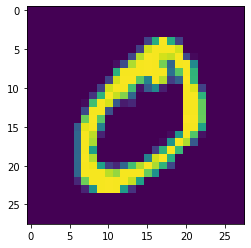

In [20]:
image = x_train[1]
plt.imshow(image)

In [7]:
print(model.predict(np.array([image/255])))

[[-5.8680277  8.024975  -2.825469  -1.2626964 -3.4956007 -8.04437
  -5.942238  -0.9878815 -1.7844296 -4.2466717]]


In [8]:
image = (image / 255 ) * 256
image = image.flatten().astype(int)

In [9]:
with open("image.txt", "w") as f:
    f.write("(")
    for i in range(len(image)):
        f.write(str(image[i]) + ",")
    f.write(")")

In [9]:
intermediate_weights = (model.layers[1].get_weights()[0] * 256).astype(int)
intermediate_output = (model.layers[1].get_weights()[1] * 256).astype(int)

final_weights = (model.layers[2].get_weights()[0] * 256).astype(int)
final_output = (model.layers[2].get_weights()[1] * 256).astype(int)

In [10]:
intermediate_output = ((np.matmul(image, intermediate_weights) + intermediate_output)/256).astype(int)
intermediate_output[intermediate_output < 0] = 0

In [11]:
final_output = ((np.matmul(intermediate_output, final_weights) + final_output)/256).astype(int)

In [12]:
(final_output/256).astype(int)

array([-5,  7, -2,  0, -3, -8, -5, -1, -1, -4])

In [18]:
intermediate_output = (model.layers[1].get_weights()[1] * 256).astype(int)
np.matmul(image, intermediate_weights)


array([-230098,  458052,  -14760,  105402,  -51754,   46457,  234960,
       -315140, -179447,  260815, -160265,  -11646,  114748, -250047,
         32117,   95648,  -33208,  173253,  -71085,   41927,  -51776,
         76360,  458309, -146348,  121354,   90980, -168328,  109746,
       -112405, -221665,  -22787,   -9310,  169006,   -5212, -171059,
       -169062,  -34771,  -58807, -261178,   51283,  105610,  -82767,
       -318507, -177013,  341552, -203324, -161330,  -62834,  265910,
          6746,   81779,  160026,  206826,   -5573,  -60007,     346,
       -163558,  222100,  405326, -136554,  215739,  -58310,  125147,
         44043, -878497,  365996, -220064,  197517, -258282,   66206,
        125777,    9492,  -48517,  -47691,   16711, -116321,  203201,
        154864,  120326,   98572,  -71106,  217617,   98387, -213332,
         86855,  -37516, -111400,  -75135,    7941, -225302,  -13484,
        134339,  -60891,  174355,   62514, -257469, -187037,  115045,
        -33139,   56

In [17]:
print(final_weights)

[[-144  -17   42 -126  -37   65   89 -113  -10   71]
 [  82  -52 -185   15   59   21   73   -2 -129   80]
 [ -82  -28  -52   -4   61   81 -163   56  -51   64]
 [  -2   38   58    6 -107  -50  -43  -39   35   -8]
 [ -43  101 -136 -105  157  -33   42  -38  -52 -128]
 [ -59   39   43  -18   47  -20   59  -90   17  -19]
 [  50  -70   53  -53   -2  -50   22   27   48   52]
 [   1  -10    1   46    6   -2  -33  -90   90  -23]
 [ -80   20   32   26    5  -52  -70   29   42   18]
 [  62   -7  -14   73   -6  -37   24   96 -103  -97]
 [ -33   84  126   35  -39    8   -8   -1   11 -164]
 [  66  -42  -67   20  -50   86   32  -60   48  -55]
 [ -47   58   55   11  -98    0  -88   38   -4   35]
 [  -4   97  -63  -36  -54   65  -63   43 -148   97]
 [ -71  -50    9 -105   49 -116   86   75  -27   30]
 [  28  -29   62  -24 -101   -1   10   -7  -40 -107]
 [  13    2   47   44   60  -54   23  -23  -42 -107]
 [   5   34   42  -22 -107    0  -42   17   44  -53]
 [-110   -6   17    0  -68  -19  -33   55   37